In [1]:
import logging
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm

sys.path.append(os.path.abspath("../.."))
from spectrum.utils.random import set_random_state
from spectrum.models import ARIMA

logging.basicConfig(level=logging.INFO)

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams.update(
    {
        "axes.edgecolor": "0.3",
        "axes.linewidth": 0.8,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.titleweight": "bold",
        "legend.fontsize": 10,
        "figure.dpi": 120,
        "legend.frameon": False,
    }
)
set_random_state()

In [2]:
selected_ids = [4, 17, 33]

results_dir = "../../results/models/arima"
os.makedirs(results_dir, exist_ok=True)


def find_best_threshold(scores, true_labels, thresholds=None):
    if thresholds is None:
        # use percentiles as candidate thresholds
        thresholds = [np.percentile(scores, p) for p in range(50, 100, 1)]
        # add some extra threshold points
        thresholds.extend([np.percentile(scores, p) for p in [99.5, 99.9]])

    best_f1 = 0
    best_threshold = thresholds[0]
    best_metrics = {}

    for threshold in thresholds:
        pred_labels = (scores > threshold).astype(int)

        # calculate confusion matrix
        TP = ((true_labels == 1) & (pred_labels == 1)).sum()
        FP = ((true_labels == 0) & (pred_labels == 1)).sum()
        TN = ((true_labels == 0) & (pred_labels == 0)).sum()
        FN = ((true_labels == 1) & (pred_labels == 0)).sum()

        # calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_metrics = {
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'fnr': fnr,
                'fpr': fpr,
                'tp': TP,
                'fp': FP,
                'tn': TN,
                'fn': FN
            }

    return best_threshold, best_metrics


def process_single_id(data_id):
    print(f"processing: {data_id}")

    train_data = pl.read_csv(f"../../datasets/Yahoo/train/A1/{data_id}.csv")
    test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{data_id}.csv")
    complete_data = pl.read_csv(f"../../datasets/Yahoo/data/A1Benchmark/{data_id}.csv")

    print("  training model...")
    model = ARIMA()
    start_time = time.time()
    model.fit(train_data["value"])
    training_time = time.time() - start_time

    print("  anomaly detection...")
    start_time = time.time()
    scores = model.predict(test_data["value"])
    scoring_time = time.time() - start_time

    train_len = len(train_data)
    test_len = len(test_data)
    test_true_labels = complete_data["label"][train_len:train_len + test_len].to_numpy()
    scores_array = scores.to_numpy()

    print("  finding best threshold...")
    best_threshold, best_metrics = find_best_threshold(scores_array, test_true_labels)

    complete_values = complete_data["value"].to_numpy()
    complete_labels = complete_data["label"].to_numpy()
    complete_timestamps = complete_data["timestamp"] if "timestamp" in complete_data.columns else range(
        len(complete_values))

    complete_predictions = np.zeros(len(complete_values))
    complete_predictions[train_len:train_len + test_len] = (scores_array > best_threshold).astype(int)

    result_df = pd.DataFrame({
        'timestamp': complete_timestamps,
        'value': complete_values,
        'label': complete_labels,
        'predicted': complete_predictions,
        'anomaly_score': np.concatenate(
            [np.zeros(train_len), scores_array, np.zeros(len(complete_values) - train_len - test_len)])
    })

    output_file = os.path.join(results_dir, f"{data_id}.csv")
    result_df.to_csv(output_file, index=False)
    print(f"  results saved to: {output_file}")

    return {
        'id': data_id,
        'training_time': training_time,
        'testing_time': scoring_time,
        'total_time': training_time + scoring_time,
        'train_samples': len(train_data),
        'test_samples': test_len,
        'best_threshold': best_threshold,
        **best_metrics
    }


all_results = []
print(f"processing {len(selected_ids)} datasets...")

for data_id in tqdm(selected_ids, desc="processing"):
    try:
        result = process_single_id(data_id)
        all_results.append(result)

        print(f"  ID {data_id} completed:")
        print(f"    best_threshold: {result['best_threshold']:.4f}")
        print(f"    f1: {result['f1']:.4f}")
        print(f"    precision: {result['precision']:.4f}")
        print(f"    recall: {result['recall']:.4f}")
        print(f"    accuracy: {result['accuracy']:.4f}")

    except Exception as e:
        print(f"  processing {data_id} failed: {str(e)}")
        continue

if all_results:
    summary_df = pd.DataFrame(all_results)
    summary_file = os.path.join(results_dir, "arima.csv")
    summary_df.to_csv(summary_file, index=False)
    print(f"summary results saved to: {summary_file}")

    print("\n" + "=" * 80)
    print("ARIMA anomaly detection")
    print("=" * 80)
    print(f"processed {len(all_results)} datasets")
    print(f"average F1: {summary_df['f1'].mean():.4f} ± {summary_df['f1'].std():.4f}")
    print(f"average precision: {summary_df['precision'].mean():.4f} ± {summary_df['precision'].std():.4f}")
    print(f"average recall: {summary_df['recall'].mean():.4f} ± {summary_df['recall'].std():.4f}")
    print(f"average accuracy: {summary_df['accuracy'].mean():.4f} ± {summary_df['accuracy'].std():.4f}")
    print(f"average training time: {summary_df['training_time'].mean():.2f}s")
    print(f"average scoring time: {summary_df['testing_time'].mean():.2f}s")
    print("=" * 80)

    print("details:")
    display_cols = ['id', 'f1', 'precision', 'recall', 'accuracy', 'best_threshold', 'tp', 'fp', 'tn', 'fn']
    print(summary_df[display_cols].round(4))
else:
    print("no results")

processing 3 datasets...


processing:   0%|          | 0/3 [00:00<?, ?it/s]

processing: 4
  training model...
  anomaly detection...


processing:  33%|███▎      | 1/3 [00:13<00:26, 13.42s/it]

  finding best threshold...
  results saved to: ../../results/models/arima/4.csv
  ID 4 completed:
    best_threshold: 586.2696
    f1: 0.5161
    precision: 0.3636
    recall: 0.8889
    accuracy: 0.9789
processing: 17
  training model...
  anomaly detection...


processing:  67%|██████▋   | 2/3 [00:37<00:19, 19.66s/it]

  finding best threshold...
  results saved to: ../../results/models/arima/17.csv
  ID 17 completed:
    best_threshold: 515.2066
    f1: 0.5778
    precision: 0.4860
    recall: 0.7123
    accuracy: 0.7865
processing: 33
  training model...
  anomaly detection...


processing: 100%|██████████| 3/3 [01:24<00:00, 28.22s/it]

  finding best threshold...
  results saved to: ../../results/models/arima/33.csv
  ID 33 completed:
    best_threshold: 951.1646
    f1: 1.0000
    precision: 1.0000
    recall: 1.0000
    accuracy: 1.0000
summary results saved to: ../../results/models/arima/arima.csv

ARIMA anomaly detection
processed 3 datasets
average F1: 0.6980 ± 0.2634
average precision: 0.6165 ± 0.3377
average recall: 0.8671 ± 0.1451
average accuracy: 0.9218 ± 0.1176
average training time: 6.11s
average scoring time: 22.09s
details:
   id      f1  precision  recall  accuracy  best_threshold   tp   fp   tn  fn
0   4  0.5161     0.3636  0.8889    0.9789        586.2696    8   14  689   1
1  17  0.5778     0.4860  0.7123    0.7865        515.2066  104  110  456  42
2  33  1.0000     1.0000  1.0000    1.0000        951.1646    1    0  719   0


In [3]:
# ARIMA模型可视化分析
import matplotlib.pyplot as plt

def visualize_arima_process(dataset_id, model=None):
    """
    可视化ARIMA模型的预测过程
    
    Args:
        dataset_id: 数据集ID
        model: ARIMA模型实例（可选）
    """
    
    # 加载数据
    train_data = pl.read_csv(f"../../datasets/Yahoo/train/A1/{dataset_id}.csv")
    test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{dataset_id}.csv")
    complete_data = pl.read_csv(f"../../datasets/Yahoo/data/A1Benchmark/{dataset_id}.csv")
    
    train_values = train_data['value'].to_numpy()
    test_values = test_data['value'].to_numpy()
    
    # 创建或使用提供的模型
    if model is None:
        model = ARIMA()
        model.fit(train_data['value'])
    
    # 获取预测值和异常分数
    predictions = model.predict(test_data['value'])
    anomaly_scores = predictions.to_numpy()
    
    # 获取ARIMA模型的预测值（如果可用）
    try:
        # 尝试获取模型的预测值
        fitted_values = model.model.fittedvalues if hasattr(model, 'model') else None
        forecast_values = model.model.forecast(steps=len(test_values)) if hasattr(model, 'model') else None
    except:
        fitted_values = None
        forecast_values = None
    
    # 创建可视化
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'ARIMA模型分析 - 数据集 {dataset_id}', fontsize=16, fontweight='bold')
    
    train_time = np.arange(len(train_values))
    test_time = np.arange(len(train_values), len(train_values) + len(test_values))
    all_time = np.arange(len(train_values) + len(test_values))
    all_values = np.concatenate([train_values, test_values])
    
    # 子图1: 训练数据 vs 测试数据
    axes[0, 0].plot(train_time, train_values, 'b-', linewidth=2, label='Training Data', alpha=0.8)
    axes[0, 0].plot(test_time, test_values, 'r-', linewidth=2, label='Test Data', alpha=0.8)
    axes[0, 0].axvline(x=len(train_values)-1, color='gray', linestyle=':', alpha=0.7, label='Train/Test Split')
    
    # 如果有拟合值，显示它们
    if fitted_values is not None and len(fitted_values) > 0:
        fit_time = train_time[-len(fitted_values):]
        axes[0, 0].plot(fit_time, fitted_values, 'g--', linewidth=1.5, label='Fitted Values', alpha=0.7)
    
    axes[0, 0].set_title('Training vs Test Data')
    axes[0, 0].set_xlabel('Time Points')
    axes[0, 0].set_ylabel('Values')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 子图2: 预测值 vs 实际值（如果有预测值）
    if forecast_values is not None:
        axes[0, 1].plot(test_time, test_values, 'r-', linewidth=2, label='Actual Test Data', alpha=0.8)
        axes[0, 1].plot(test_time, forecast_values, 'orange', linewidth=2, label='ARIMA Forecast', alpha=0.8)
        axes[0, 1].fill_between(test_time, test_values, forecast_values, alpha=0.3, color='yellow', label='Prediction Error')
        axes[0, 1].set_title('ARIMA Forecast vs Actual')
    else:
        # 如果没有预测值，显示残差分析
        axes[0, 1].plot(test_time, test_values, 'r-', linewidth=2, label='Test Data', alpha=0.8)
        axes[0, 1].plot(test_time, anomaly_scores, 'purple', linewidth=2, label='Anomaly Scores', alpha=0.8)
        axes[0, 1].set_title('Test Data vs Anomaly Scores')
    
    axes[0, 1].set_xlabel('Time Points')
    axes[0, 1].set_ylabel('Values')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 子图3: 异常分数分布
    axes[1, 0].plot(test_time, anomaly_scores, 'purple', linewidth=2, label='Anomaly Scores')
    axes[1, 0].fill_between(test_time, anomaly_scores, alpha=0.3, color='purple')
    axes[1, 0].set_title('Anomaly Scores Over Time')
    axes[1, 0].set_xlabel('Time Points')
    axes[1, 0].set_ylabel('Anomaly Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 子图4: 异常分数直方图
    axes[1, 1].hist(anomaly_scores, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(np.mean(anomaly_scores), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {np.mean(anomaly_scores):.2f}')
    axes[1, 1].axvline(np.median(anomaly_scores), color='orange', linestyle='--', 
                      linewidth=2, label=f'Median: {np.median(anomaly_scores):.2f}')
    axes[1, 1].set_title('Anomaly Score Distribution')
    axes[1, 1].set_xlabel('Anomaly Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("=== ARIMA Model Statistics ===")
    print(f"Training Data Length: {len(train_values)}")
    print(f"Test Data Length: {len(test_values)}")
    print(f"Training Data Range: [{np.min(train_values):.4f}, {np.max(train_values):.4f}]")
    print(f"Test Data Range: [{np.min(test_values):.4f}, {np.max(test_values):.4f}]")
    print(f"Anomaly Scores Range: [{np.min(anomaly_scores):.4f}, {np.max(anomaly_scores):.4f}]")
    print(f"Mean Anomaly Score: {np.mean(anomaly_scores):.4f}")
    print(f"Std Anomaly Score: {np.std(anomaly_scores):.4f}")
    
    return fig

def visualize_arima_anomaly_detection(dataset_id, threshold=None):
    """
    可视化ARIMA异常检测结果
    """
    # 加载数据
    train_data = pl.read_csv(f"../../datasets/Yahoo/train/A1/{dataset_id}.csv")
    test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{dataset_id}.csv")
    complete_data = pl.read_csv(f"../../datasets/Yahoo/data/A1Benchmark/{dataset_id}.csv")
    
    train_values = train_data['value'].to_numpy()
    test_values = test_data['value'].to_numpy()
    
    # 获取真实标签
    train_len = len(train_data)
    test_len = len(test_data)
    true_labels = complete_data["label"][train_len:train_len + test_len].to_numpy()
    
    # 训练模型并获取异常分数
    model = ARIMA()
    model.fit(train_data['value'])
    anomaly_scores = model.predict(test_data['value']).to_numpy()
    
    # 如果没有提供阈值，使用最佳阈值
    if threshold is None:
        threshold, _ = find_best_threshold(anomaly_scores, true_labels)
    
    # 识别异常点
    predicted_anomalies = anomaly_scores > threshold
    true_anomalies = true_labels == 1
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle(f'ARIMA异常检测结果 - 数据集 {dataset_id}', fontsize=16, fontweight='bold')
    
    train_time = np.arange(len(train_values))
    test_time = np.arange(len(train_values), len(train_values) + len(test_values))
    
    # 子图1: 完整数据与真实异常点
    axes[0].plot(train_time, train_values, 'b-', linewidth=2, label='Training Data', alpha=0.8)
    axes[0].plot(test_time, test_values, 'g-', linewidth=2, label='Test Data', alpha=0.8)
    axes[0].axvline(x=len(train_values)-1, color='gray', linestyle=':', alpha=0.7, label='Train/Test Split')
    
    if np.any(true_anomalies):
        anomaly_indices = test_time[true_anomalies]
        anomaly_values = test_values[true_anomalies]
        axes[0].scatter(anomaly_indices, anomaly_values, 
                       color='red', s=60, label=f'True Anomalies ({np.sum(true_anomalies)})', zorder=5)
    
    axes[0].set_title('Complete Data with True Anomalies')
    axes[0].set_xlabel('Time Points')
    axes[0].set_ylabel('Values')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 子图2: 测试数据与预测异常点
    axes[1].plot(test_time, test_values, 'g-', linewidth=2, label='Test Data', alpha=0.8)
    
    if np.any(predicted_anomalies):
        pred_anomaly_indices = test_time[predicted_anomalies]
        pred_anomaly_values = test_values[predicted_anomalies]
        axes[1].scatter(pred_anomaly_indices, pred_anomaly_values, 
                       color='orange', s=60, label=f'Predicted Anomalies ({np.sum(predicted_anomalies)})', zorder=5)
    
    axes[1].set_title(f'Test Data with Predicted Anomalies (Threshold: {threshold:.2f})')
    axes[1].set_xlabel('Time Points')
    axes[1].set_ylabel('Values')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 子图3: 异常分数与阈值
    axes[2].plot(test_time, anomaly_scores, 'purple', linewidth=2, label='Anomaly Scores')
    axes[2].fill_between(test_time, anomaly_scores, alpha=0.3, color='purple')
    axes[2].axhline(y=threshold, color='red', linestyle='--', 
                   linewidth=2, label=f'Threshold ({threshold:.2f})')
    
    # 高亮异常区域
    if np.any(predicted_anomalies):
        axes[2].fill_between(test_time, threshold, anomaly_scores, 
                            where=(anomaly_scores > threshold), 
                            color='red', alpha=0.3, label='Anomaly Regions')
    
    axes[2].set_title('Anomaly Scores and Threshold')
    axes[2].set_xlabel('Time Points')
    axes[2].set_ylabel('Anomaly Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 计算性能指标
    TP = np.sum((true_anomalies == 1) & (predicted_anomalies == 1))
    FP = np.sum((true_anomalies == 0) & (predicted_anomalies == 1))
    TN = np.sum((true_anomalies == 0) & (predicted_anomalies == 0))
    FN = np.sum((true_anomalies == 1) & (predicted_anomalies == 0))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
    print("=== ARIMA Detection Results ===")
    print(f"True Anomalies: {np.sum(true_anomalies)}")
    print(f"Predicted Anomalies: {np.sum(predicted_anomalies)}")
    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"True Negatives: {TN}")
    print(f"False Negatives: {FN}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    return fig

def compare_arima_datasets(dataset_ids=None):
    """
    比较多个数据集的ARIMA结果
    """
    if dataset_ids is None:
        dataset_ids = selected_ids
    
    fig, axes = plt.subplots(len(dataset_ids), 3, figsize=(18, 6*len(dataset_ids)))
    if len(dataset_ids) == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('ARIMA模型跨数据集比较', fontsize=16, fontweight='bold')
    
    for i, dataset_id in enumerate(dataset_ids):
        # 加载数据
        train_data = pl.read_csv(f"../../datasets/Yahoo/train/A1/{dataset_id}.csv")
        test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{dataset_id}.csv")
        
        train_values = train_data['value'].to_numpy()
        test_values = test_data['value'].to_numpy()
        
        # 训练模型并获取异常分数
        model = ARIMA()
        model.fit(train_data['value'])
        anomaly_scores = model.predict(test_data['value']).to_numpy()
        
        train_time = np.arange(len(train_values))
        test_time = np.arange(len(train_values), len(train_values) + len(test_values))
        
        # 训练数据
        axes[i, 0].plot(train_time, train_values, 'b-', linewidth=2, label=f'Dataset {dataset_id}')
        axes[i, 0].set_title(f'Training Data - Dataset {dataset_id}')
        axes[i, 0].set_xlabel('Time Points')
        axes[i, 0].set_ylabel('Values')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].legend()
        
        # 测试数据
        axes[i, 1].plot(test_time, test_values, 'g-', linewidth=2, label=f'Dataset {dataset_id}')
        axes[i, 1].set_title(f'Test Data - Dataset {dataset_id}')
        axes[i, 1].set_xlabel('Time Points')
        axes[i, 1].set_ylabel('Values')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].legend()
        
        # 异常分数
        axes[i, 2].plot(test_time, anomaly_scores, 'purple', linewidth=2, label=f'Dataset {dataset_id}')
        axes[i, 2].fill_between(test_time, anomaly_scores, alpha=0.3, color='purple')
        axes[i, 2].set_title(f'Anomaly Scores - Dataset {dataset_id}')
        axes[i, 2].set_xlabel('Time Points')
        axes[i, 2].set_ylabel('Anomaly Score')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

def visualize_arima_residuals(dataset_id):
    """
    可视化ARIMA模型的残差分析
    """
    # 加载数据
    train_data = pl.read_csv(f"../../datasets/Yahoo/train/A1/{dataset_id}.csv")
    test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{dataset_id}.csv")
    
    train_values = train_data['value'].to_numpy()
    test_values = test_data['value'].to_numpy()
    
    # 训练模型
    model = ARIMA()
    model.fit(train_data['value'])
    
    # 获取残差（如果可用）
    try:
        if hasattr(model, 'model') and hasattr(model.model, 'resid'):
            residuals = model.model.resid
        else:
            # 如果没有残差，计算预测误差
            predictions = model.predict(train_data['value'])
            residuals = train_values[-len(predictions):] - predictions.to_numpy()
    except:
        residuals = None
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'ARIMA残差分析 - 数据集 {dataset_id}', fontsize=16, fontweight='bold')
    
    if residuals is not None and len(residuals) > 0:
        time_axis = np.arange(len(residuals))
        
        # 残差时间序列
        axes[0, 0].plot(time_axis, residuals, 'r-', linewidth=1, alpha=0.8)
        axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0, 0].set_title('Residuals Over Time')
        axes[0, 0].set_xlabel('Time Points')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 残差直方图
        axes[0, 1].hist(residuals, bins=30, alpha=0.7, color='red', edgecolor='black')
        axes[0, 1].axvline(np.mean(residuals), color='blue', linestyle='--', 
                          linewidth=2, label=f'Mean: {np.mean(residuals):.4f}')
        axes[0, 1].set_title('Residuals Distribution')
        axes[0, 1].set_xlabel('Residual Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Q-Q图（简化版）
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot (Normal Distribution)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # ACF图（简化版）
        # 计算自相关
        def autocorr(x, max_lags=20):
            n = len(x)
            x = x - np.mean(x)
            autocorrs = np.correlate(x, x, mode='full')
            autocorrs = autocorrs[n-1:]
            autocorrs = autocorrs / autocorrs[0]
            return autocorrs[:max_lags+1]
        
        lags = np.arange(21)
        acf_values = autocorr(residuals, 20)
        
        axes[1, 1].bar(lags, acf_values, alpha=0.7, color='blue')
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1, 1].axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='5% Significance')
        axes[1, 1].axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].set_title('Autocorrelation of Residuals')
        axes[1, 1].set_xlabel('Lag')
        axes[1, 1].set_ylabel('Autocorrelation')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        print("=== Residuals Statistics ===")
        print(f"Mean: {np.mean(residuals):.6f}")
        print(f"Std: {np.std(residuals):.6f}")
        print(f"Min: {np.min(residuals):.6f}")
        print(f"Max: {np.max(residuals):.6f}")
        print(f"Skewness: {stats.skew(residuals):.6f}")
        print(f"Kurtosis: {stats.kurtosis(residuals):.6f}")
        
    else:
        for ax in axes.flat:
            ax.text(0.5, 0.5, 'Residuals not available', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=14)
            ax.set_title('No Residuals Data')
    
    plt.tight_layout()
    plt.show()
    
    return fig

=== ARIMA模型可视化演示 ===

1. 分析数据集 4 的ARIMA模型过程:


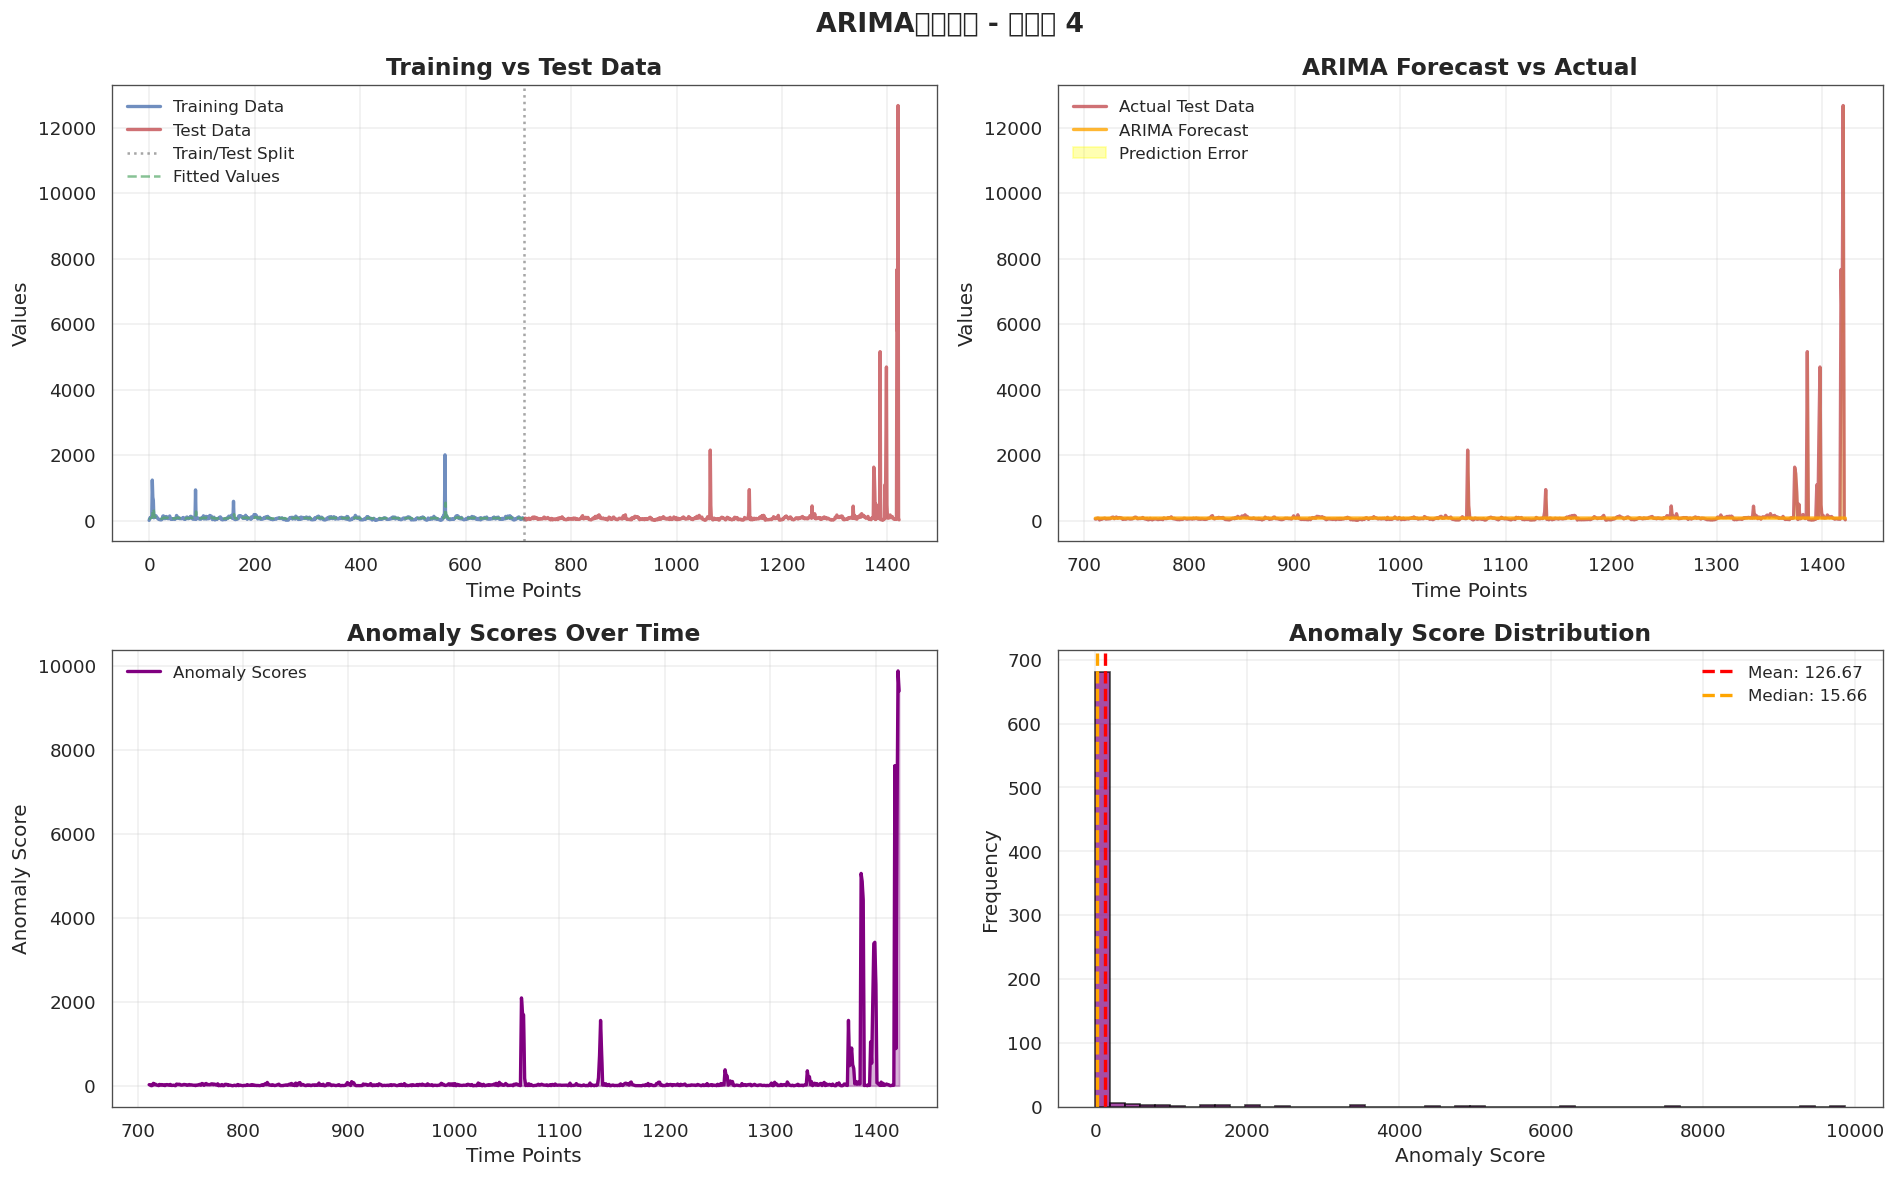

=== ARIMA Model Statistics ===
Training Data Length: 711
Test Data Length: 712
Training Data Range: [5.0000, 2005.0000]
Test Data Range: [5.0000, 12673.0000]
Anomaly Scores Range: [0.0053, 9876.3481]
Mean Anomaly Score: 126.6735
Std Anomaly Score: 744.9464

2. 分析数据集 4 的异常检测结果:


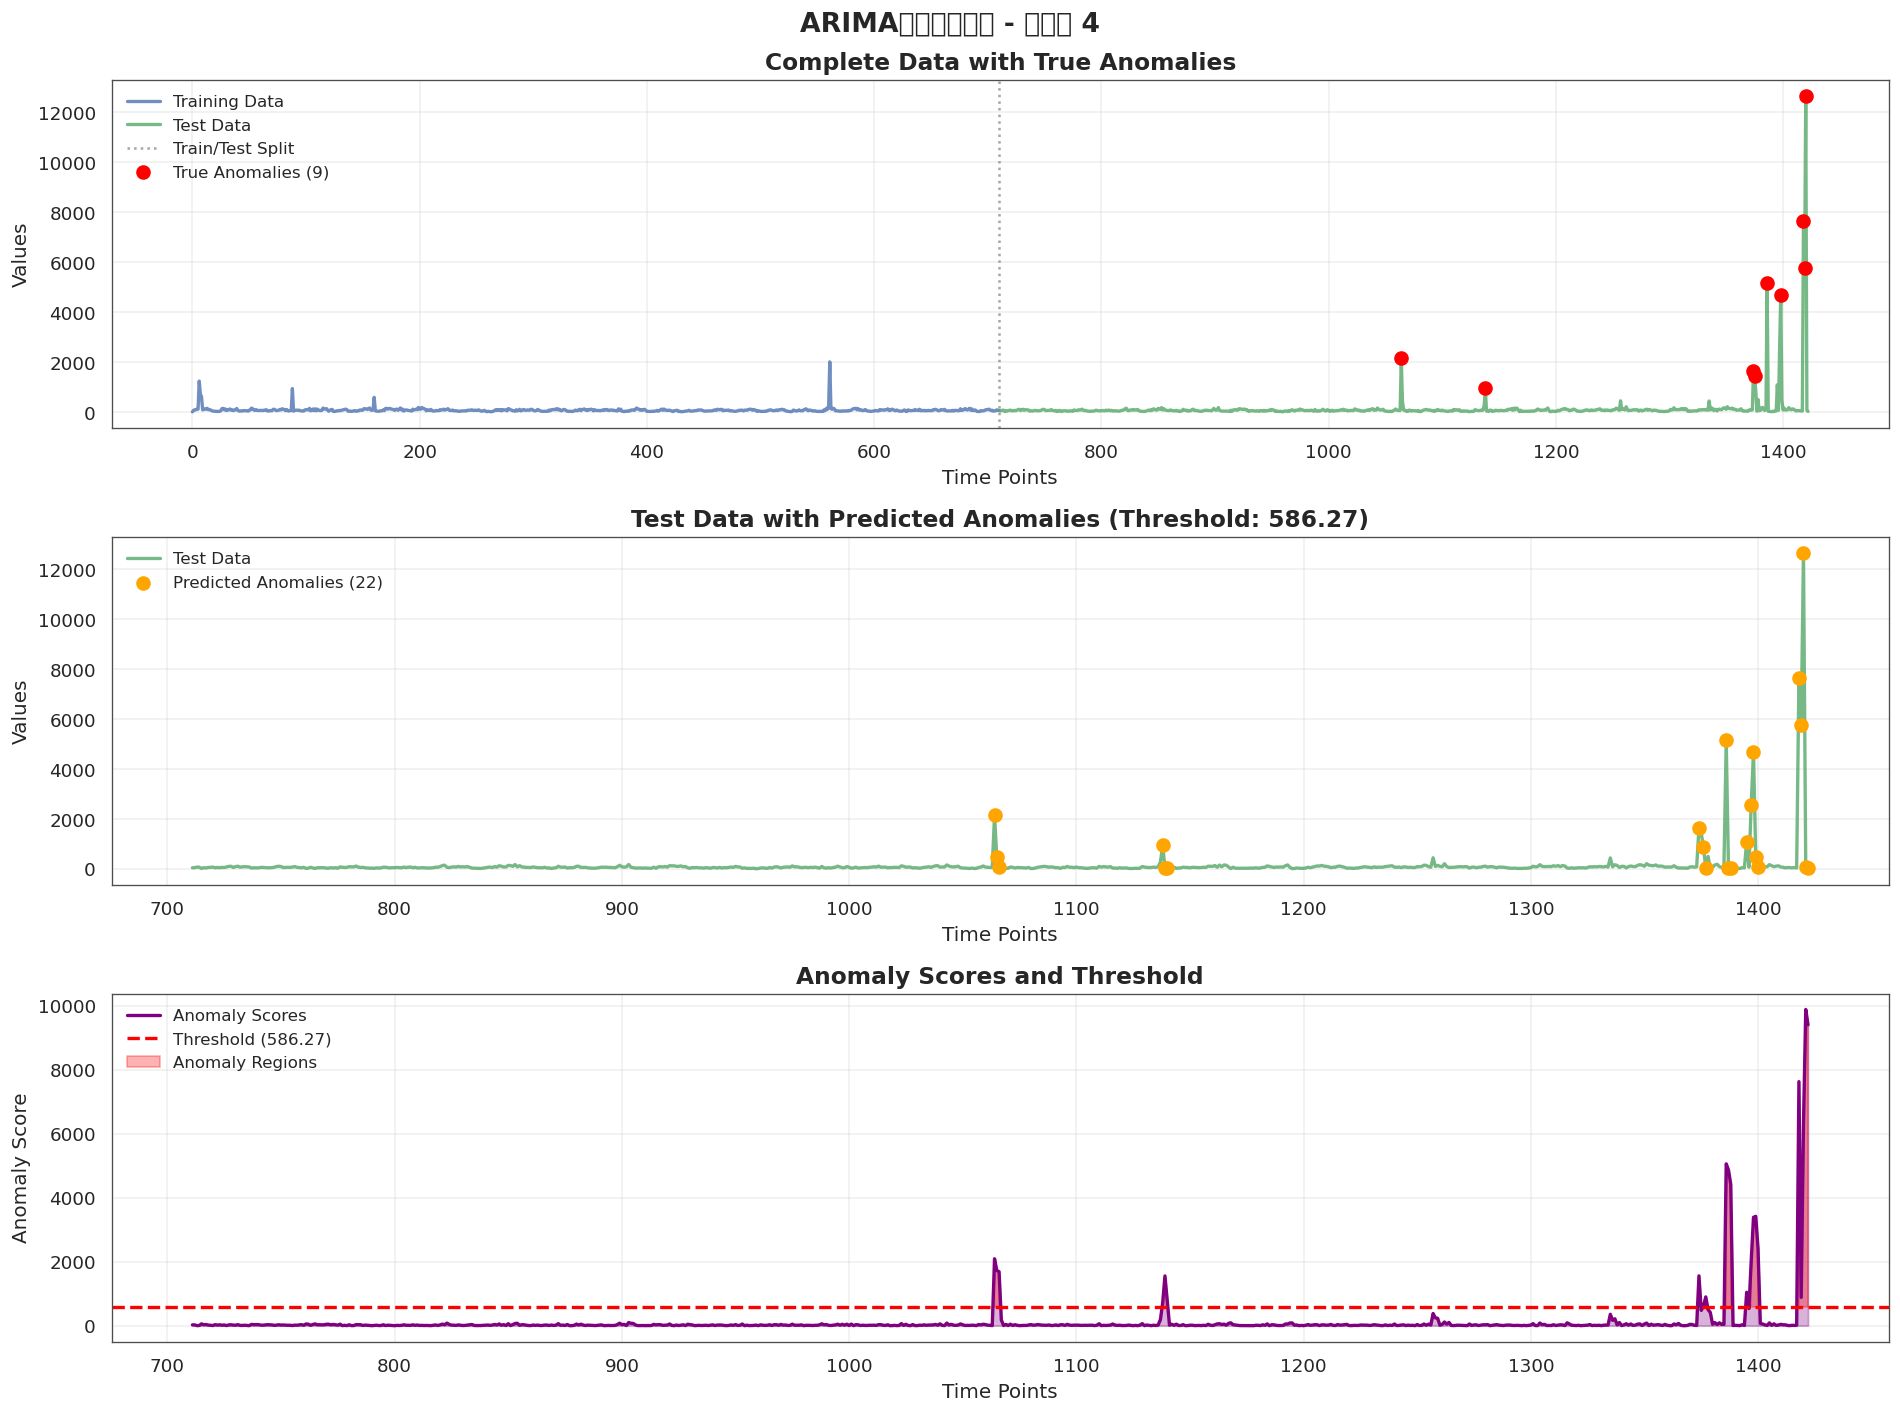

=== ARIMA Detection Results ===
True Anomalies: 9
Predicted Anomalies: 22
True Positives: 8
False Positives: 14
True Negatives: 689
False Negatives: 1
Precision: 0.3636
Recall: 0.8889
F1-Score: 0.5161
Accuracy: 0.9789

3. 分析数据集 4 的残差:
=== Residuals Statistics ===
Mean: -0.006319
Std: 99.040778
Min: -419.514411
Max: 1886.054173
Skewness: 13.003020
Kurtosis: 217.524338


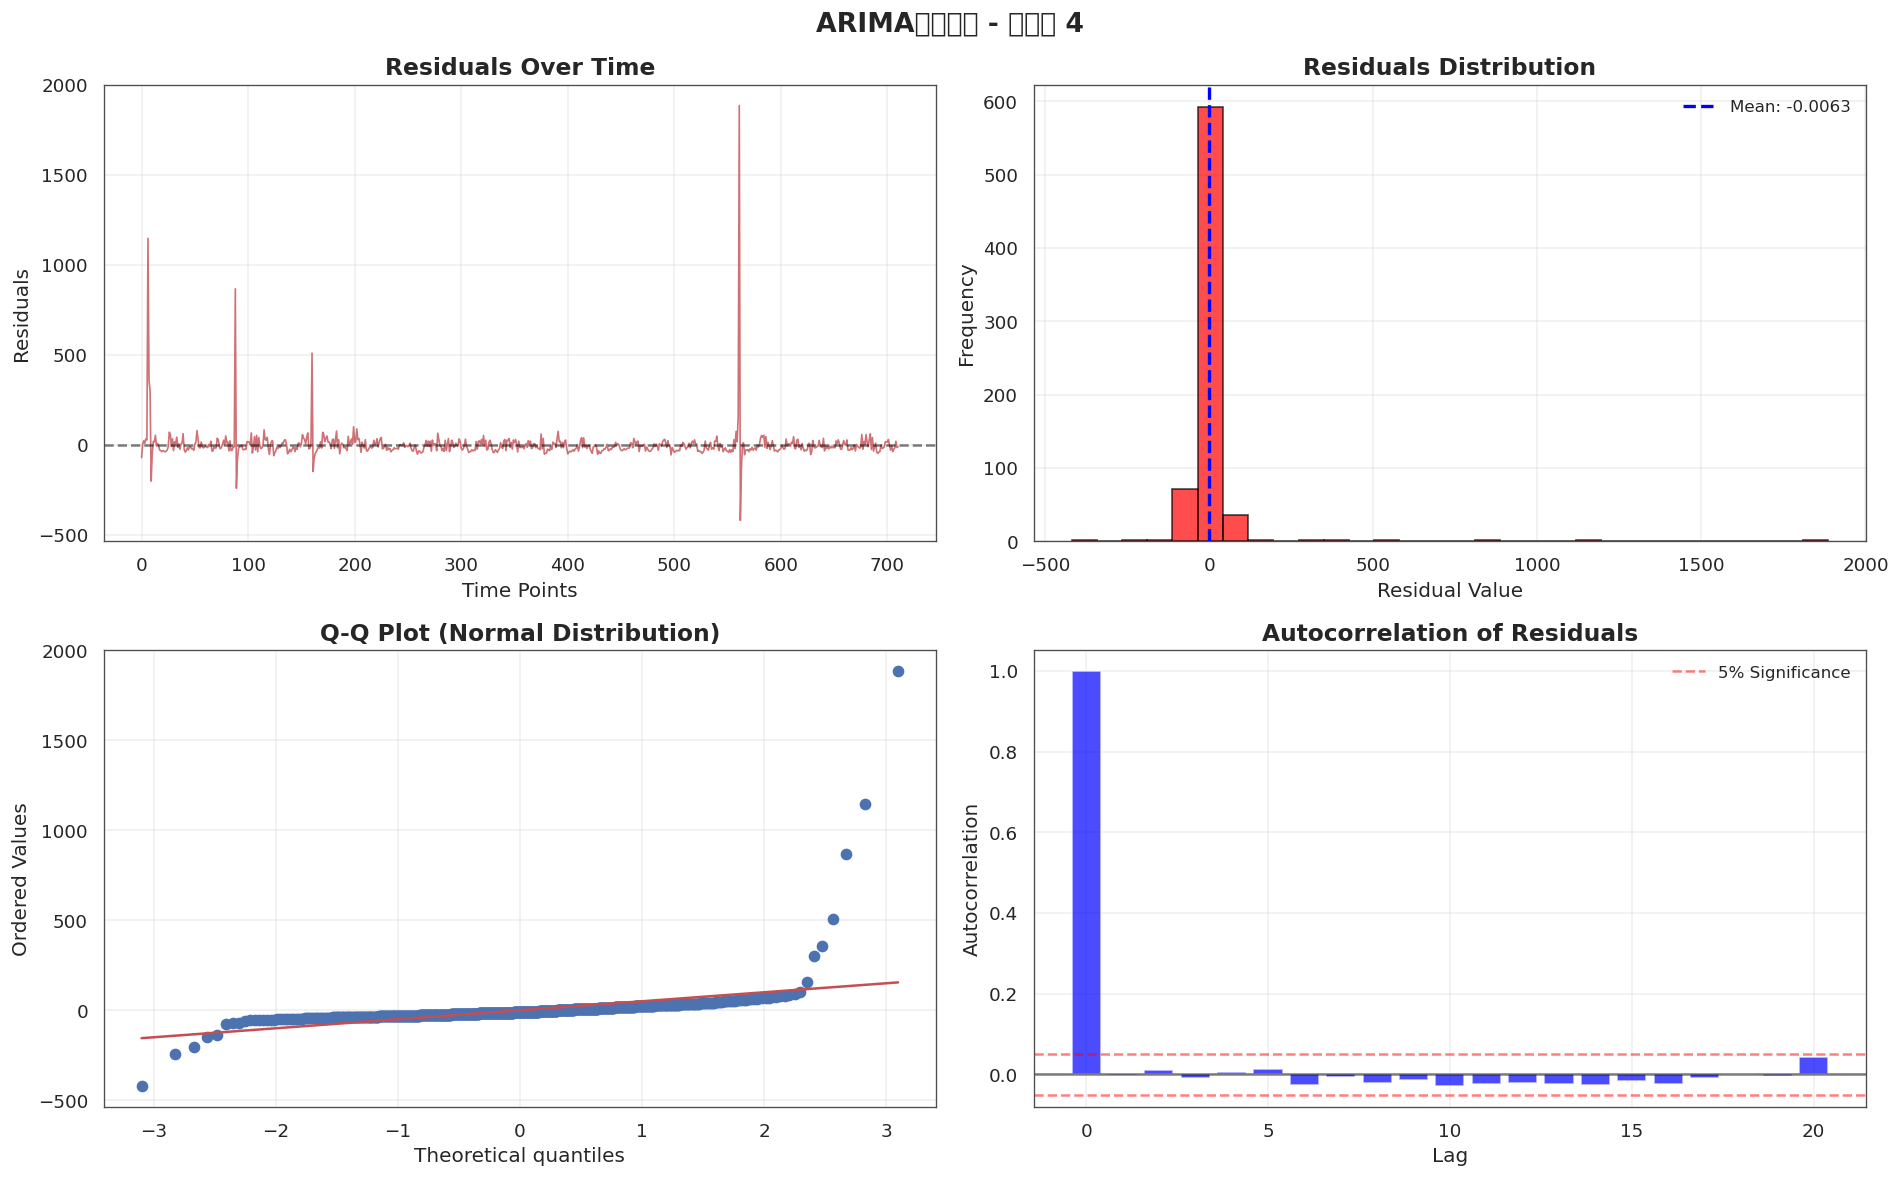


4. 比较所有数据集的ARIMA结果:


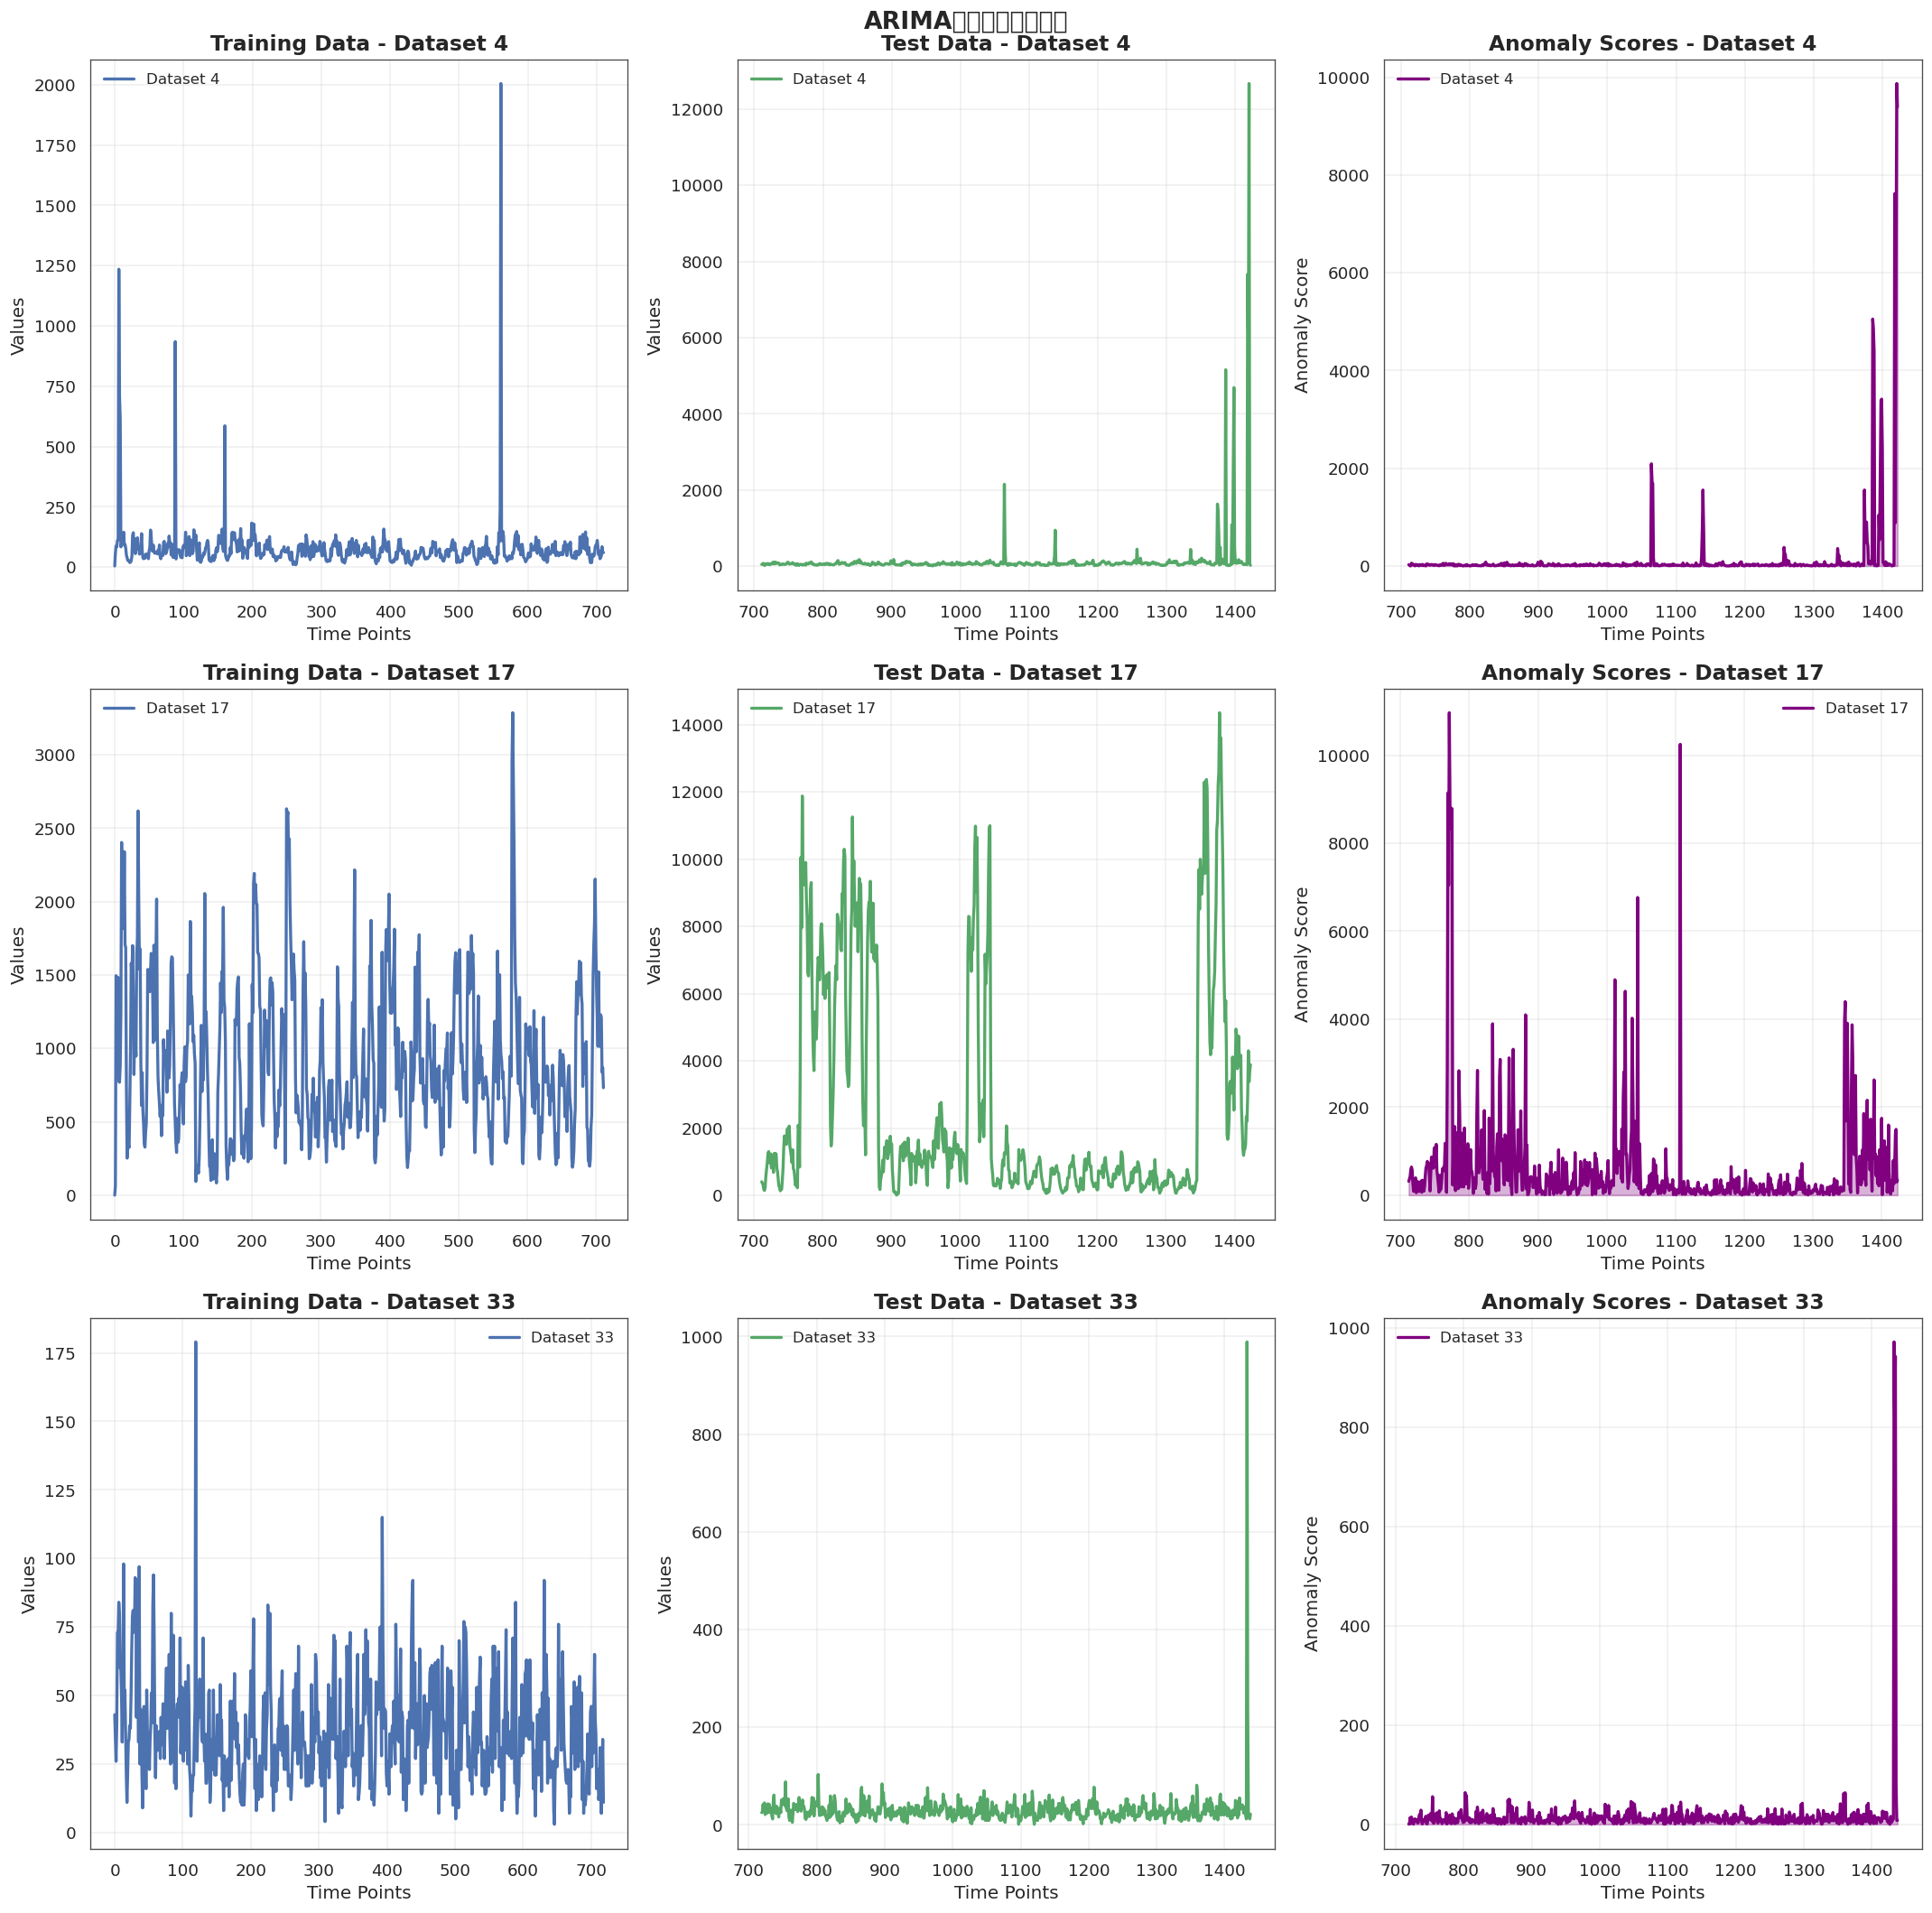

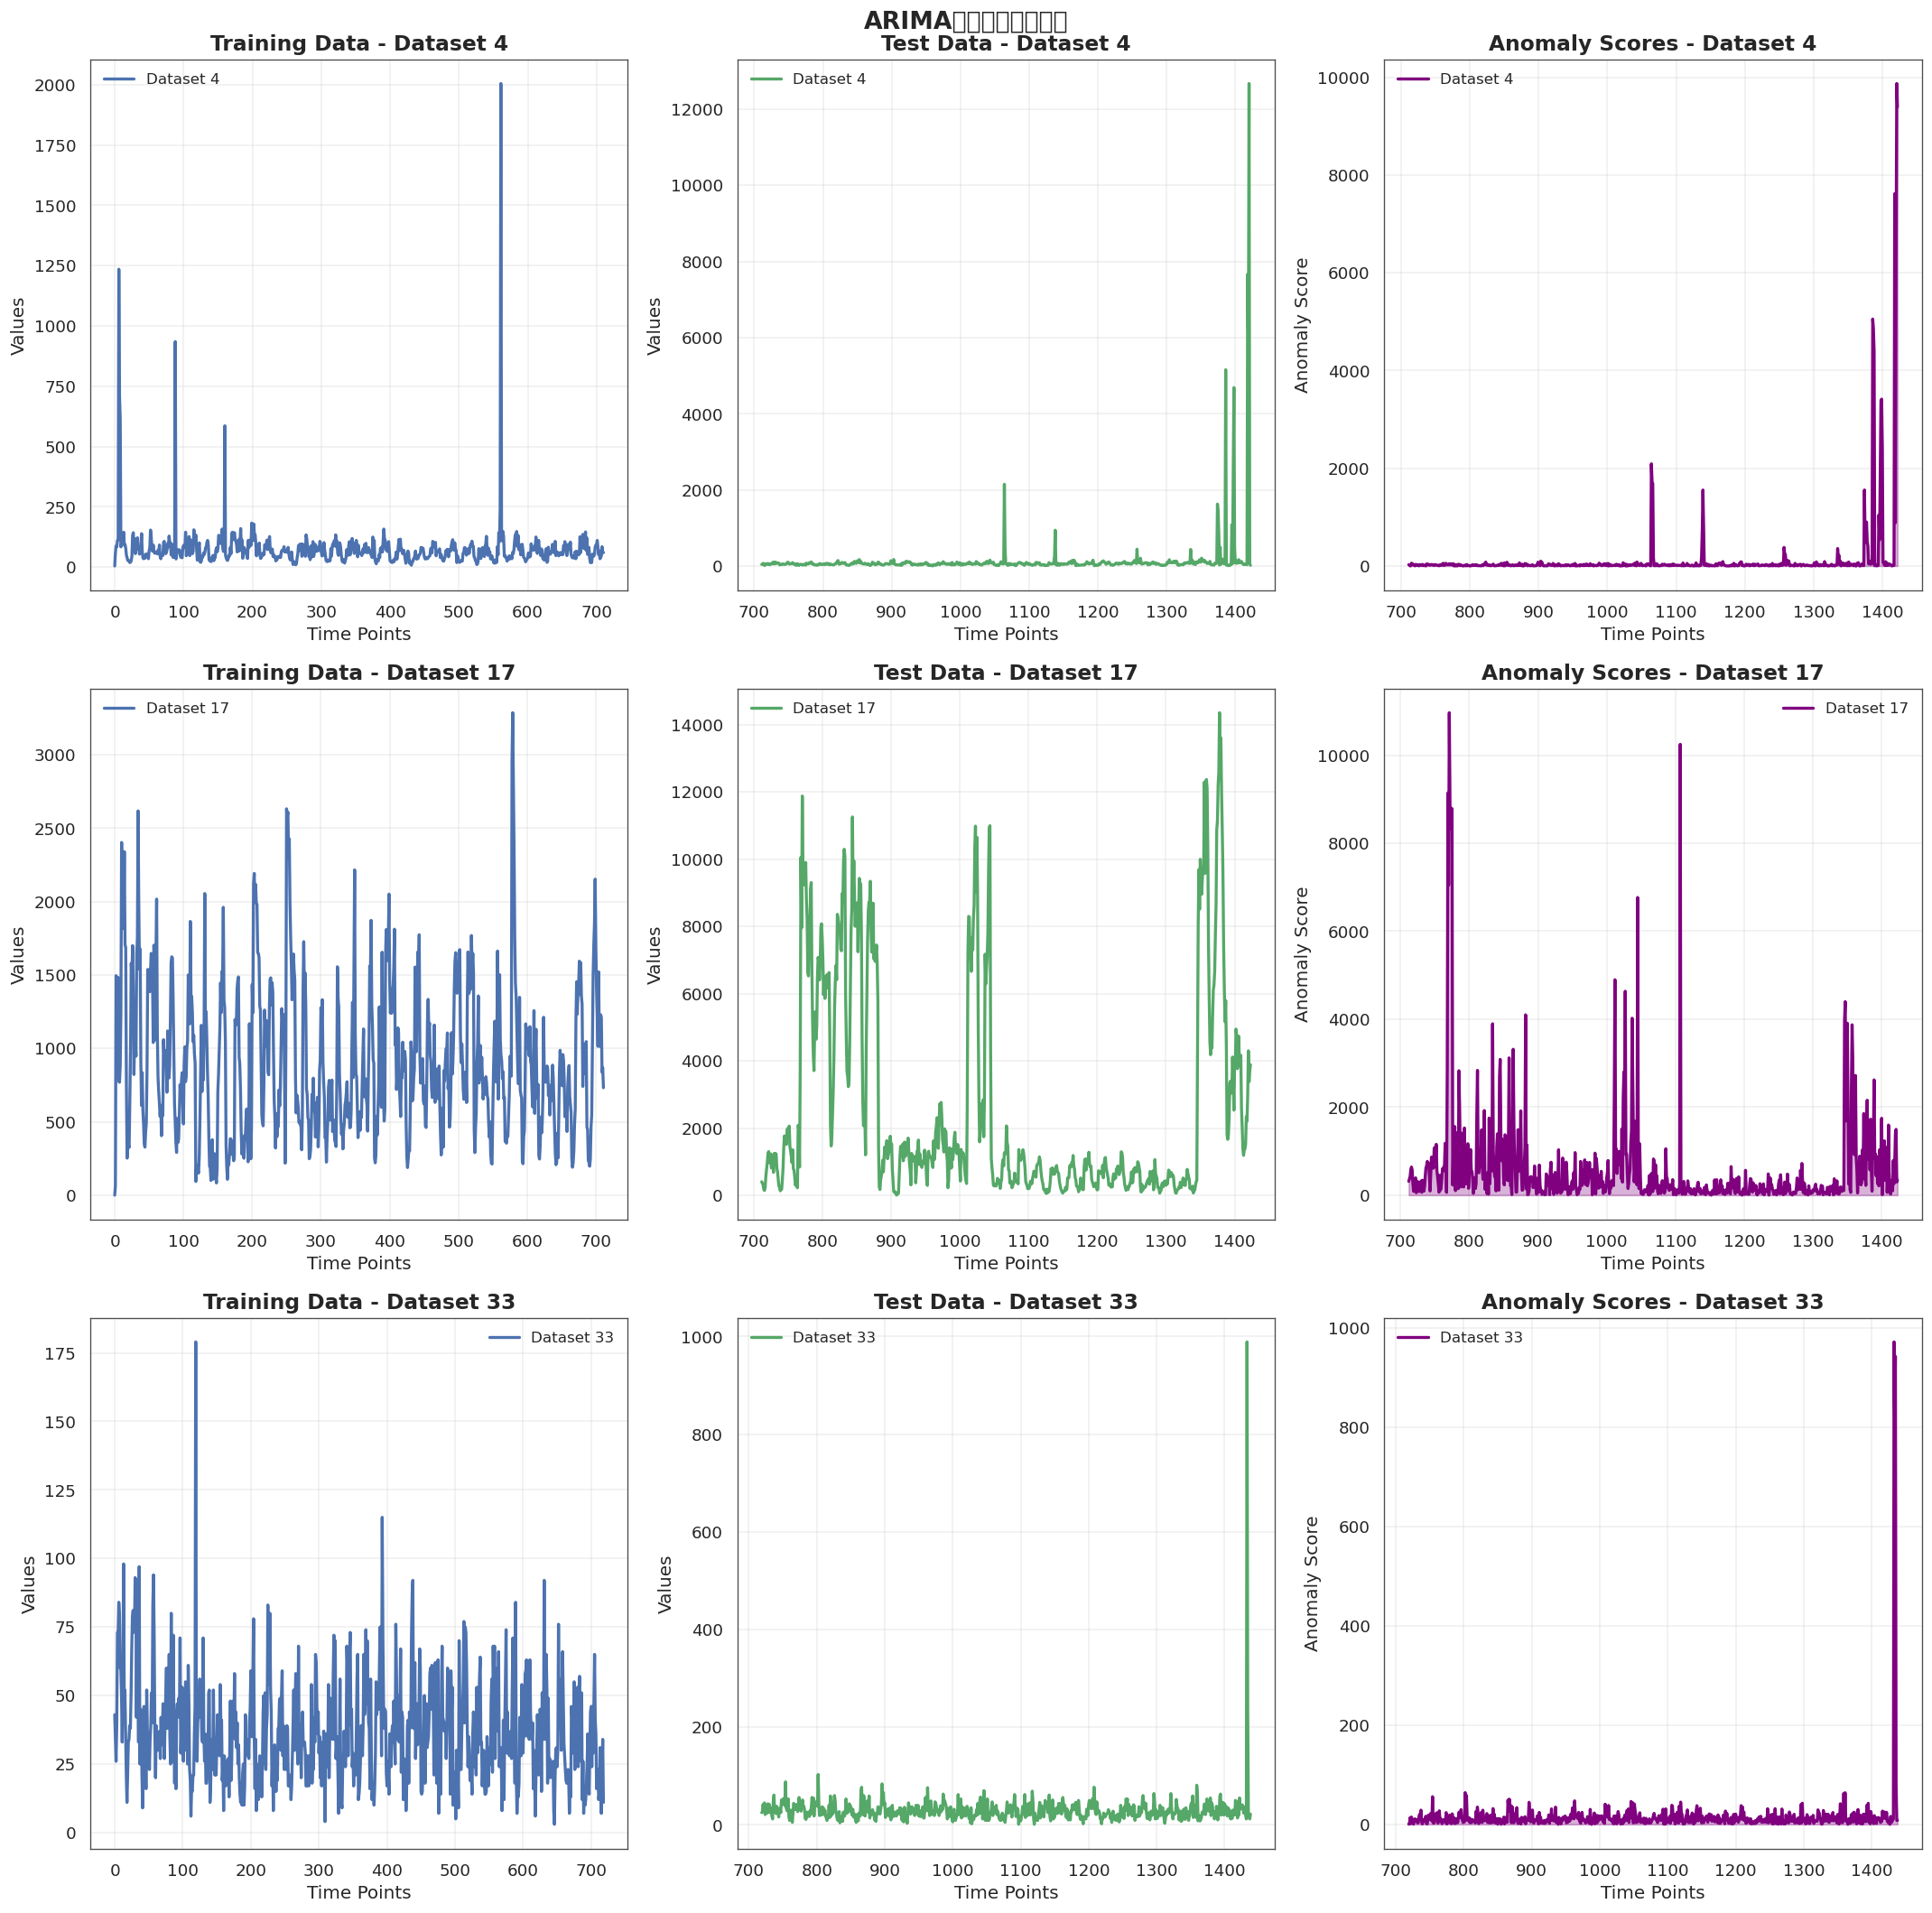

In [4]:
# 演示ARIMA可视化功能
print("=== ARIMA模型可视化演示 ===")

# 选择一个数据集进行详细分析
demo_dataset_id = 4

print(f"\n1. 分析数据集 {demo_dataset_id} 的ARIMA模型过程:")
visualize_arima_process(demo_dataset_id)

print(f"\n2. 分析数据集 {demo_dataset_id} 的异常检测结果:")
visualize_arima_anomaly_detection(demo_dataset_id)

print(f"\n3. 分析数据集 {demo_dataset_id} 的残差:")
visualize_arima_residuals(demo_dataset_id)

print(f"\n4. 比较所有数据集的ARIMA结果:")
compare_arima_datasets(selected_ids)